<a href="https://colab.research.google.com/github/Existanze54/sirius-neural-networks-2024/blob/main/Practices/05S_NN_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар

**Классификация нормы и опухоли на гистологических снимках.**

In [ ]:
import os
import warnings

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from tqdm import tqdm


warnings.filterwarnings('ignore')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
  print(torch.cuda.get_device_properties(device))

cuda:0
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


Установим пакет для работы с данными набора MedMNIST.

In [ ]:
pip install --upgrade git+https://github.com/MedMNIST/MedMNIST.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/MedMNIST/MedMNIST.git to /tmp/pip-req-build-179maboh
  Running command git clone -q https://github.com/MedMNIST/MedMNIST.git /tmp/pip-req-build-179maboh
     |████████████████████████████████| 87 kB 2.8 MB/s 
  Created wheel for medmnist: filename=medmnist-2.1.0-py3-none-any.whl size=21641 sha256=ac144ab1682af2c09f7076371b9482980d8f21cf03dfa0e52ebe9b0652e46b2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-x7em_rlr/wheels/97/75/cd/860a928b0738c787736602e16fdca953dcfc47087767e76f72
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=3b9af9226c7adbfcda40a2896f1b70928f2b33a0338f76c7a12e14360e76add5
  Stored in directory: /root/.cache/pip/wheels/1f/10/06/2a990ee4d73a8479fe2922445e8a876d38cfbfed052284c6a1
Successfully built medmnist fire


In [ ]:
import medmnist
from medmnist import INFO, Evaluator

Нас интересует датасет PathMNIST с фотографиями гистологических препаратов толстой кишки.

In [ ]:
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

Загрузим тренировочные данные.

In [ ]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = DataClass(split='train', transform=data_transform, download=download)

  0%|          | 0/205615438 [00:00<?, ?it/s]

**Найдите среднее и стандартное отклонение для нормализации данных.**

In [ ]:
data_ = torch.Tensor([data[0].numpy() for data in train_dataset])
means = data_.mean(dim=[0,2,3])
stds = data_.std(dim=[0,2,3])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

In [ ]:
data_.shape

In [ ]:
means, stds

Нормализуем данные с использованием найденных параметров, обёртываем датасеты в даталоадеры.

In [ ]:
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

BATCH_SIZE = 128

train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


Посмотрим на описание данных и на некоторые примеры.

In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into train

In [ ]:
train_dataset.montage(length=1)

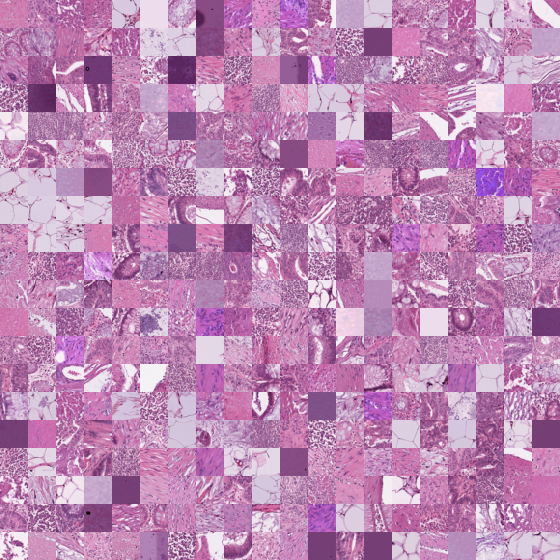

In [ ]:
train_dataset.montage(length=20)

**Используя код в следующей ячейке, создайте следующие нейронные сети (для каждой сохраняйте результат):**
 1. С использованием сигмоиды как функции активации;
 2. С использованием ReLU как функции активации;
* a). Без BatchNorm;
* b). С BatchNorm до функции активации;
* c). С BatchNorm после функции активации.
* d)**. С BatchNorm в оптимальном из b) и c) расположений и Dropout (p=0.2) до BatchNorm;
* e)**. С BatchNorm в оптимальном из b) и c) расположений и Dropout (p=0.2) после BatchNorm.
* f) Лучшую из выбранных сетей обучить с OneCycleLR

**Сравните оптимизаторы SGD и AdamW для лучшей нейросети.**

In [ ]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.Linear(128, 128),
            ### Вставьте нужное (активацию, BatchNorm, Dropout и пр.) ###
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


device = torch.device("cuda:0")
model = Net(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()


### Количество эпох и значение коэффициента скорости обучения можно менять!
NUM_EPOCHS = 3
lr = 0.001

optimizer = optim.AdamW(model.parameters(), lr=0.01)

In [ ]:
#help(nn.BatchNorm2d)

Проведём обучение и посмотрим результаты на тесте.

In [ ]:
def train(model):
    print('==> Training ...')
    for epoch in range(NUM_EPOCHS):
      model.train()
      for inputs, targets in tqdm(train_loader):

          inputs = inputs.to(device)
          targets = targets.to(device)

          # forward + backward + optimize
          optimizer.zero_grad()
          outputs = model(inputs)

          if task == 'multi-label, binary-class':
              targets = targets.to(torch.float32)
              loss = criterion(outputs, targets)
          else:
              targets = targets.squeeze()
              loss = criterion(outputs, targets)

          loss.backward()
          optimizer.step()
    print('\n ==> Finished training')

In [ ]:
def test_split(model, split):
    model.eval()
    y_score = torch.tensor([]).to(device)

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze()
                outputs = outputs.softmax(dim=-1)

            y_score = torch.cat((y_score, outputs), 0)

        y_score = y_score.cpu().detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

def test(model):
    print('==> Evaluating ...')
    test_split(model, 'train')
    test_split(model, 'test')

In [ ]:
train(model)

In [ ]:
test(model)

In [ ]:
# 1. Sigmoid, no BatchNorm, SGD usual
# 2. Sigmoid, no BatchNorm, SGD with momentum
# 3. Sigmoid, no BatchNorm, AdamW
# 4. Sigmoid, with BatchNorm, AdamW
# 5. ReLU, with BatchNorm, AdamW

# 6. Dropouts

# 7. ReLU, with BatchNorm, AdamW, OneCycleLR

Пробуем настроить OneCycleLR

In [ ]:
start_lr = 1e-8
end_lr = 10
lr_find_epochs = 1
steps = lr_find_epochs * len(train_loader)
smoothing = 0.05

model = Net(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)

import math

lrs = []
losses = []
optimizer = optim.AdamW(model.parameters(), lr=1e-8)
lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (steps))


scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

for epoch in tqdm(range(lr_find_epochs)):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()
        scheduler.step()

        loss = loss.detach().cpu().numpy()
        if len(losses) > 1:
            loss = smoothing * loss + (1 - smoothing) * losses[-1]
        losses.append(loss)
        lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
        lrs.append(lr_step)

100%|██████████| 1/1 [00:21<00:00, 21.26s/it]


Text(0, 0.5, 'Loss')

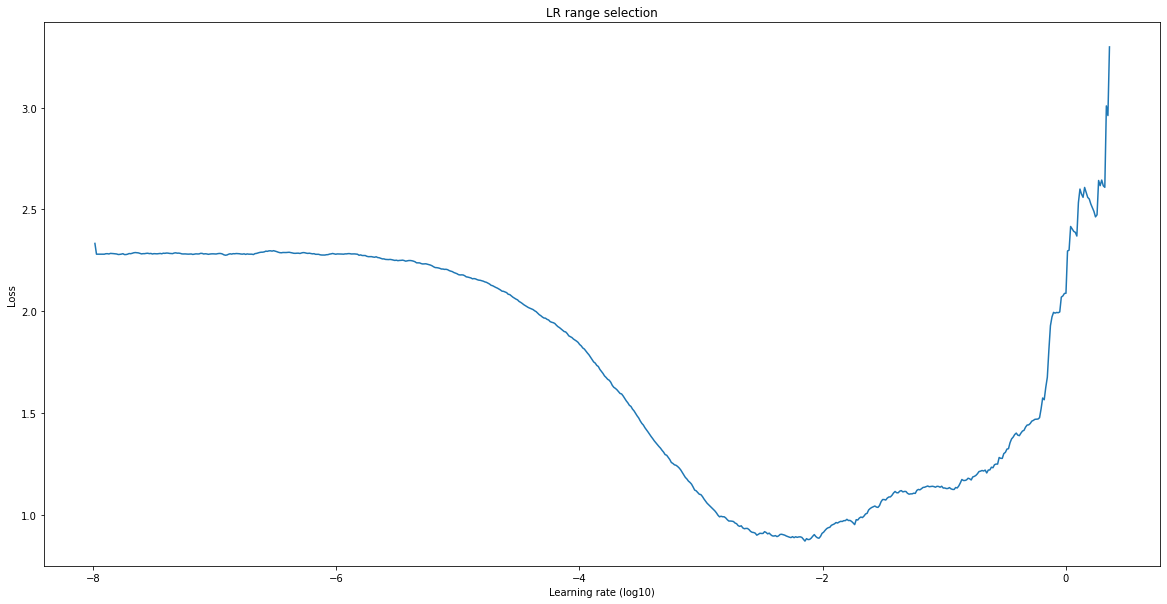

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("LR range selection")
plt.plot(np.log10(lrs[:-50]), losses[:-50])
plt.xlabel("Learning rate (log10)")
plt.ylabel("Loss")

Запускаем OneCycleLR

In [ ]:
max_lr = 1e-2
div_factor = 25
min_lr = max_lr / div_factor
device = torch.device("cuda:0")
model = Net(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()


### Количество эпох и значение коэффициента скорости обучения можно менять!
NUM_EPOCHS = 3

optimizer = optim.AdamW(model.parameters(), lr=min_lr)

batch_per_epoch = len(train_loader)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                        max_lr=max_lr,
                       steps_per_epoch=batch_per_epoch,
                       epochs=NUM_EPOCHS,
                       pct_start=0.3,#default
                       three_phase=False,
                       div_factor=div_factor)

In [ ]:
for epoch in range(NUM_EPOCHS):

    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()
        scheduler.step()

100%|██████████| 704/704 [00:19<00:00, 35.29it/s]


In [ ]:
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  acc: 0.998  auc:0.956
test  acc: 0.984  auc:0.850
